# Welcome to `arcospy`!

`arcospy` is the python sister software module to the original R arcos package maintained by the [Washington Post](https://github.com/wpinvestigative/arcos). Here we will demonstrate how to download some arcos data and how to make the data spatial. We also hint at some advanced usage! 

If you would like an introduction to the ARCOS data, check out the original *Washington Post* article [here](https://www.washingtonpost.com/graphics/2019/investigations/dea-pain-pill-database/). If you would like an introduction to working with `arcospy`, we recommend the notebook `Intro to arcospy - downloading data and making it spatial`.

This notebook will focus on examining some basic use cases of the pharmacy data.

# Setting up the workspace

As before, we want to make sure that `arcospy` is installed and that we can import the module.

In [3]:
!pip install arcospy
import arcospy

# Loading in the pharmacy data for an entire state

Let's consider the pharmacy data for all the pharmacies in Minnesota. We can get this data using the `total_pharmacies_state()` command as below:

In [8]:
MN_pharm = arcospy.total_pharmacies_state(state='MN', key='WaPo')
MN_pharm.head()

,buyer_state,buyer_county,buyer_dea_no,buyer_name,buyer_city,total_dosage_unit,total_records
0,MN,HENNEPIN,BU6084177,OMNICARE - MINNESOTA,BROOKLYN CENTER,12602200,3081
1,MN,ANOKA,BP5822209,PHARMERICA,FRIDLEY,7196820,5785
2,MN,HENNEPIN,FH0062151,HCMC P-1 PHARMACY,MINNEAPOLIS,6016100,3439
3,MN,SAINT LOUIS,AW2819273,WALGREEN CO.,DULUTH,5682900,6490
4,MN,SAINT LOUIS,AW3645150,WALGREEN CO.,DULUTH,5589900,6686


From here we are quite close to generating per-capita pharmaceutical counts. Although we have `total_dosage_units`, we still need county `population` to standardize the data. Let's grab it with the `county_population` command.

In [11]:
MN_county_pop = arcospy.county_population(state="MN", key="WaPo")
MN_county_pop.tail()

,BUYER_COUNTY,BUYER_STATE,countyfips,STATE,COUNTY,county_name,NAME,variable,year,population
778,WATONWAN,MN,27165,27,165,Watonwan,"Watonwan County, Minnesota",B01003_001,2014,11151
779,WILKIN,MN,27167,27,167,Wilkin,"Wilkin County, Minnesota",B01003_001,2014,6561
780,WINONA,MN,27169,27,169,Winona,"Winona County, Minnesota",B01003_001,2014,51285
781,WRIGHT,MN,27171,27,171,Wright,"Wright County, Minnesota",B01003_001,2014,127386
782,YELLOW MEDICINE,MN,27173,27,173,Yellow Medicine,"Yellow Medicine County, Minnesota",B01003_001,2014,10233


Note that this population data is available across several years.

In [12]:
MN_county_pop.year.value_counts()

2014    87
2013    87
2012    87
2011    87
2010    87
2009    87
2008    87
2007    87
2006    87
Name: year, dtype: int64

So let's get the average population by county and year before merging it to the pharmacy data.

In [16]:
MN_county_pop_avg = MN_county_pop.groupby('BUYER_COUNTY').mean().reset_index()
MN_county_pop_avg.head()

,BUYER_COUNTY,STATE,COUNTY,year,population
0,AITKIN,27.0,1.0,2010.0,16213.444444
1,ANOKA,27.0,3.0,2010.0,329144.000000
2,BECKER,27.0,5.0,2010.0,32371.333333
3,BELTRAMI,27.0,7.0,2010.0,44054.666667
4,BENTON,27.0,9.0,2010.0,38453.888889


Great! We can now merge this information into the `MN_pharm` dataset.

In [21]:
import pandas as pd
MN_merge = pd.merge(MN_pharm, MN_county_pop_avg, left_on='buyer_county', right_on='BUYER_COUNTY')
MN_merge.head()

,buyer_state,buyer_county,buyer_dea_no,buyer_name,buyer_city,total_dosage_unit,total_records,BUYER_COUNTY,STATE,COUNTY,year,population
0,MN,HENNEPIN,BU6084177,OMNICARE - MINNESOTA,BROOKLYN CENTER,12602200,3081,HENNEPIN,27.0,53.0,2010.0,1.145884e+06
1,MN,HENNEPIN,FH0062151,HCMC P-1 PHARMACY,MINNEAPOLIS,6016100,3439,HENNEPIN,27.0,53.0,2010.0,1.145884e+06
2,MN,HENNEPIN,BA9104112,ALLINA HEALTH HEART HOSPITAL PHARMACY,MINNEAPOLIS,4670744,4762,HENNEPIN,27.0,53.0,2010.0,1.145884e+06
3,MN,HENNEPIN,BF9051260,FAIRVIEW EDINA PHARMACY,EDINA,3901930,6381,HENNEPIN,27.0,53.0,2010.0,1.145884e+06
4,MN,HENNEPIN,BW2234829,WALGREEN CO.,MINNEAPOLIS,3468300,5325,HENNEPIN,27.0,53.0,2010.0,1.145884e+06


Let's now calculate the number of pills per person per pharmacy averaged over the 9 year study period: 

*pills per person per pharmacy = total dosage unit / population / 9*

In python:

In [25]:
MN_merge['pills_per_person'] = MN_merge['total_dosage_unit']/MN_merge['population']/9
MN_merge.head()

,buyer_state,buyer_county,buyer_dea_no,buyer_name,buyer_city,total_dosage_unit,total_records,BUYER_COUNTY,STATE,COUNTY,year,population,pills_per_person
0,MN,HENNEPIN,BU6084177,OMNICARE - MINNESOTA,BROOKLYN CENTER,12602200,3081,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,1.221977
1,MN,HENNEPIN,FH0062151,HCMC P-1 PHARMACY,MINNEAPOLIS,6016100,3439,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.583353
2,MN,HENNEPIN,BA9104112,ALLINA HEALTH HEART HOSPITAL PHARMACY,MINNEAPOLIS,4670744,4762,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.452900
3,MN,HENNEPIN,BF9051260,FAIRVIEW EDINA PHARMACY,EDINA,3901930,6381,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.378352
4,MN,HENNEPIN,BW2234829,WALGREEN CO.,MINNEAPOLIS,3468300,5325,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.336305


Note that the resulting numbers are small because we are in Hennepin County, MN, one of the most densely populated counties in Minnesota. If we look at the maximum value for a given pharmacy across MN, that number jumps up quite a bit:

In [26]:
MN_merge.iloc[MN_merge['pills_per_person'].idxmax()] 

buyer_state                          MN
buyer_county                       COOK
buyer_dea_no                  FA0259071
buyer_name           ARROWHEAD PHARMACY
buyer_city                 GRAND MARAIS
total_dosage_unit                939040
total_records                      2164
BUYER_COUNTY                       COOK
STATE                                27
COUNTY                               31
year                               2010
population                         5235
pills_per_person                19.9308
Name: 1756, dtype: object

The above suggests that there were nearly 20 pills per person (for over 5000 people!) for the above record. But is this value an extreme outlier? Let's look at the distribution of the `pills_per_person` column:

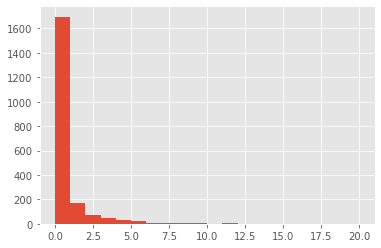

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(MN_merge['pills_per_person'], 
         bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
               11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.show()

We can see that the 19.93 value from the above record seems to be an extreme outlier compared to the rest of the the data in Minnesota. 

# Mapping the pharmacy data

Perhaps a better way to visualize the distribution of the data is via a [proportional symbol map](http://wiki.gis.com/wiki/index.php/Proportional_symbol_map). Let's gather the Lat and Lon of each pharmacy using the `pharm_latlon` command.

Unfortunately, this function is limited to one county at a time. We will use a loop to quickly build the necessary dataframe.

In [39]:
MN_Counties = ['Aitkin', 'Anoka', 'Becker', 'Beltrami', 'Benton', 'Big Stone', 'Blue Earth', 'Brown', 
               'Carlton', 'Carver', 'Cass', 'Chippewa','Chisago','Clay','Clearwater','Cook','Cottonwood',
               'Crow Wing','Dakota','Dodge','Douglas','Faribault','Fillmore','Freeborn','Goodhue','Grant',
               'Hennepin','Houston','Hubbard','Isanti','Itasca','Jackson','Kanabec','Kandiyohi','Kittson',
               'Koochiching','Lac Qui Parle','Lake','Lake Of The Wood','Le Sueur','Lincoln','Lyon','Mahnomen',
               'Marshall','Martin','McLeod','Meeker','Mille Lacs','Morrison','Mower','Murray','Nicollet','Nobles',
               'Norman','Olmsted','Otter Tail','Pennington','Pine','Pipestone','Polk','Pope','Ramsey','Red Lake',
               'Redwood','Renville','Rice','Rock','Roseau','St. Louis','Scott','Sherburne','Sibley','Stearns',
               'Steele','Stevens','Swift','Todd','Traverse','Wabasha','Wadena','Waseca','Washington','Watonwan',
               'Wilkin','Winona','Wright','Yellow Medicine']

In [38]:
# Build an empty dataframe
MN_pharm_latlon = pd.DataFrame()

In [48]:
for i in MN_Counties:
    try:
        temp = arcospy.pharm_latlon(county = i, state = 'MN', key = 'WaPo')
        MN_pharm_latlon = MN_pharm_latlon.append(temp)
    except:
        pass

In [52]:
MN_pharm_latlon.head()

,BUYER_DEA_NO,BUYER_STATE,BUYER_COUNTY,lat,lon,error
0,BS6420804,MN,AITKIN,46.6099,-93.3139,NaN
1,FT2421547,MN,AITKIN,46.6099,-93.3139,NaN
2,AH1521853,MN,AITKIN,46.5328,-93.7056,NaN
3,FG4033940,MN,AITKIN,46.5328,-93.7056,NaN
4,FT2421561,MN,AITKIN,46.5328,-93.7056,NaN


Let's merge the Lat and Lon data onto the existing `MN_merge` data object. 

In [68]:
MN_merge_latlon = pd.merge(MN_merge, 
                           MN_pharm_latlon, 
                           left_on='buyer_dea_no', 
                           right_on='BUYER_DEA_NO')
MN_merge_latlon.head()

,buyer_state,buyer_county,buyer_dea_no,buyer_name,buyer_city,total_dosage_unit,total_records,BUYER_COUNTY_x,STATE,COUNTY,year,population,pills_per_person,BUYER_DEA_NO,BUYER_STATE,BUYER_COUNTY_y,lat,lon,error
0,MN,HENNEPIN,BU6084177,OMNICARE - MINNESOTA,BROOKLYN CENTER,12602200,3081,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,1.221977,BU6084177,MN,HENNEPIN,45.0424,-93.3329,NaN
1,MN,HENNEPIN,FH0062151,HCMC P-1 PHARMACY,MINNEAPOLIS,6016100,3439,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.583353,FH0062151,MN,HENNEPIN,44.9725,-93.2622,NaN
2,MN,HENNEPIN,BF9051260,FAIRVIEW EDINA PHARMACY,EDINA,3901930,6381,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.378352,BF9051260,MN,HENNEPIN,44.8869,-93.3262,NaN
3,MN,HENNEPIN,BW2234829,WALGREEN CO.,MINNEAPOLIS,3468300,5325,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.336305,BW2234829,MN,HENNEPIN,44.9204,-93.2185,NaN
4,MN,HENNEPIN,BF9051359,FAIRVIEW RIVERSIDE PHARMACY,MINNEAPOLIS,3411700,6412,HENNEPIN,27.0,53.0,2010.0,1.145884e+06,0.330817,BF9051359,MN,HENNEPIN,44.9672,-93.2382,NaN


We can now plot the pharmacies using Latitude and Longitude. Let's first render a simple map of the pharmacies before moving on to the proportional symbol map. 

We first need to convert our dataframe into a geodataframe.

In [69]:
import geopandas
gdf = geopandas.GeoDataFrame(MN_merge_latlon, 
                             geometry=geopandas.points_from_xy(MN_merge_latlon.lon,
                                                               MN_merge_latlon.lat))

<AxesSubplot:>

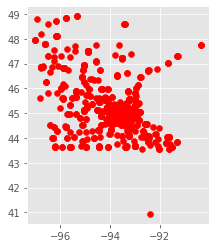

In [70]:
gdf.plot(color='red')

Note that there apepars to be one observation outside the state. As previously mentioned, such errors are possible given the number of number of pharmacies in the data. To remove it we can simply drop any points that are below a lat of 43. 

In [71]:
gdf = gdf[gdf['lat'] > 43] 

<AxesSubplot:>

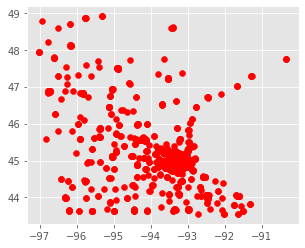

In [72]:
gdf.plot(color='red')

Great! You may already recognize the shape of Minnesota in the data. Let's now scale the points based on the value observed in `pills_per_person` and improve the cartographic layout of the map.

In [150]:
import matplotlib.pyplot as plt

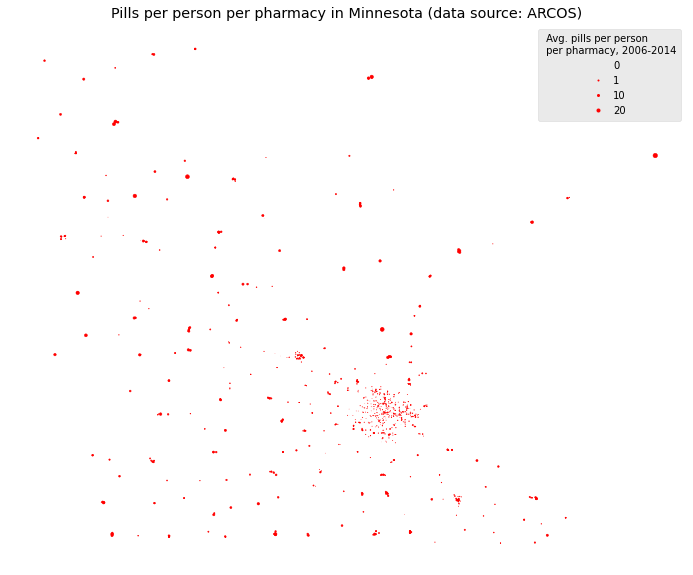

In [153]:
fig,ax = plt.subplots(figsize=(16,10), subplot_kw={'aspect':'equal'})

plot = gdf.plot(markersize = 'pills_per_person',
                color = "red", 
                ax=ax,
)

plot.set_axis_off()

plot.set_title("Pills per person per pharmacy in Minnesota (data source: ARCOS)")

# from https://stackoverflow.com/questions/24164797/creating-a-matplotlib-scatter-legend-size-related
import numpy as np
msizes = np.array([0, 1, 2, 3])

l1, = plt.plot([],[], 'or', markersize=msizes[0])
l2, = plt.plot([],[], 'or', markersize=msizes[1])
l3, = plt.plot([],[], 'or', markersize=msizes[2])
l4, = plt.plot([],[], 'or', markersize=msizes[3])

labels = ['0', '1', '10', '20']

leg = plot.legend([l1, l2, l3, l4, l5, l6], 
                  labels, ncol=1, 
                  frameon=True, fontsize=10,
                  handlelength=1, loc = 1,
                  borderpad = 0.5,
                  handletextpad=1, 
                  title=' Avg. pills per person\n per pharmacy, 2006-2014', scatterpoints = 1)



While this map is far from perfect, it is meant to get you started! Note that the extreme values make discerning between points quite difficult. However, we can tell that the largest points are certainly located outside of the downtown Minneapolis core. 